In [60]:
# Import of relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn import preprocessing
import sklearn.metrics as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import tree


from sklearn.linear_model import LogisticRegression

RSEED = 42

# Preprocessing

## Functions

In [16]:
def dropCols(df):
    drop_cols = [
        'blurb',
        'creator',
        'currency',
        'currency_trailing_code',
        'fx_rate',
        'location',
        'name',
        'profile',
        'slug',
        'source_url',
        'static_usd_rate',
        'usd_type',
        "country",
        "is_starrable",
        'converted_pledged_amount',
        'pledged',
    ]
    df.drop(drop_cols, inplace=True, axis = 1)
    for c in df.columns: 
        if df[c].dtype == "object": 
            df[c] = df[c].astype("category") 
    df.dropna(inplace=True)
    return df

def toDay(time_delta):
    return round(time_delta/3600/24,2)

def dateTimeUpdate(df):
    campaign_length = df.deadline - df.created_at
    campaign_length = campaign_length.apply(toDay)
    campaign_length.name = "campaign_length"
    
    time_until_launch = df.launched_at - df.created_at
    time_until_launch = time_until_launch.apply(toDay)
    time_until_launch.name = "time_until_launch"
    
    time_launch2state = df.state_changed_at - df.launched_at
    time_launch2state = time_launch2state.apply(toDay)
    time_launch2state.name = "time_launch2state"
    
    time_state2deadline = df.deadline - df.state_changed_at
    time_state2deadline = time_state2deadline.apply(toDay)
    time_state2deadline.name = "time_state2deadline"
    
    df = pd.concat([df, 
                    campaign_length,
                    time_until_launch, 
                    time_launch2state,
                    time_state2deadline
                   ],
                  axis = 1
                  )
    df.drop([
        "created_at",
        "deadline",
        "launched_at",
        "state_changed_at",
            ],
        axis =1,
        inplace=True
    )
    return df

## Load data, drop unnecessary columns

In [3]:
df = pd.read_csv('data/df_clean.csv')
df = dropCols(df)
df = dateTimeUpdate(df)
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.head()

,backers_count,converted_pledged_amount,disable_communication,goal,pledged,staff_pick,state,usd_pledged,category_name,category_slug,cgrouped,campaign_length,time_until_launch,time_launch2state,time_state2deadline
0,2,2,False,30000.0,3.29,False,failed,2.513164,Web,journalism/web,CA,30.04,0.03,30.01,0.0
1,2,2,False,70000.0,2.00,False,failed,2.000000,Drama,film & video/drama,US,109.09,64.09,45.00,0.0
2,119,5635,False,4000.0,5635.00,False,successful,5635.000000,Restaurants,food/restaurants,US,48.91,34.91,14.00,0.0
3,70,1317,False,500.0,1317.69,False,successful,1317.690000,Graphic Design,design/graphic design,US,68.20,47.25,20.96,0.0
4,73,5134,False,5000.0,5134.01,False,successful,5134.010000,Poetry,publishing/poetry,US,60.34,20.34,40.00,0.0


## Define categorical and numerical columns

In [4]:
cat_features = list(df.columns[df.dtypes=='category'])
cat_features.remove('state')
cat_features

['category_name', 'category_slug', 'cgrouped']

In [5]:
num_features = list(df.columns[df.dtypes!='category'])
num_features

['backers_count',
 'converted_pledged_amount',
 'disable_communication',
 'goal',
 'pledged',
 'staff_pick',
 'usd_pledged',
 'campaign_length',
 'time_until_launch',
 'time_launch2state',
 'time_state2deadline']

## Define training data

Targets will only be "failed" and "successful" because, only these are purely market driven classes and therefore can be best related to the features. To predict for example "cancelled" more insights into the founders' business would be necessary.

In [6]:
X = df[(df['state']=='failed') | (df['state']=='successful')].drop("state", axis=1)
y = df[(df['state']=='failed') | (df['state']=='successful')]["state"]
print(f"fearture Rows: {X.shape[0]} \nfeature columns: {X.shape[1]}")
print(f"target rows: {y.shape[0]}")

fearture Rows: 173168 
feature columns: 14
target rows: 173168


In [7]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(["failed","successful"])
print("before: \n{}".format(np.array(y[:10])))
y = label_encoder.transform(y)
print("-----"*10)
print("after: \n{}".format(y[:10]))

before: 
['failed' 'failed' 'successful' 'successful' 'successful' 'successful'
 'successful' 'successful' 'successful' 'successful']
--------------------------------------------------
after: 
[0 0 1 1 1 1 1 1 1 1]


## Split the training data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=RSEED)
X_train, X_train_alt, y_train, y_train_alt = train_test_split(X_train, y_train, train_size=0.1,stratify=y_train, random_state=RSEED)

## Setup the preprocessing pipeline

In [19]:
# Pipeline for numerical features 
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])
# Pipeline for categorical features
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [20]:
# Complete pipeline for numerical and categorical features
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

#preprocess validationData
preprocessor.fit(X_train)
X_test = preprocessor.transform(X_test)

# Logistic Regression

In [21]:
# LogisticRegression Classifier
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression())
])

#Grid search Parameters
param_logreg = {"logreg__penalty":['l2'],
                "logreg__dual":[False],
                "logreg__tol":[0.0001,1,5],
                "logreg__C":[1.0],
                "logreg__fit_intercept":[True],
                "logreg__intercept_scaling":[1],
                "logreg__class_weight":[None],
                "logreg__random_state":[RSEED],
                "logreg__solver":['lbfgs'],
                "logreg__max_iter":[100],
                "logreg__multi_class":['auto'],
                "logreg__verbose":[0],
                "logreg__warm_start":[False],
                "logreg__n_jobs":[None],
                "logreg__l1_ratio":[None],
               }

grid_logreg = GridSearchCV(pipe_logreg,
                           param_grid=param_logreg,
                           cv=5, 
                           scoring='accuracy',
                           verbose=5, 
                           n_jobs=-1)

In [22]:
grid_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/pmcrae/Documents/neueFische/project-kickstarter/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['backers_count',
                                                                          'converted_pledged_amount',
                                                                          'disable_communication',
                                                                          'goal',
                          

In [43]:
grid_logreg.best_params_

{'logreg__C': 1.0,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__l1_ratio': None,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'auto',
 'logreg__n_jobs': None,
 'logreg__penalty': 'l2',
 'logreg__random_state': None,
 'logreg__solver': 'lbfgs',
 'logreg__tol': 0.0001,
 'logreg__verbose': 0,
 'logreg__warm_start': False}

In [24]:
logreg_model = grid_logreg.best_estimator_['logreg']
y_log_pred_test = logreg_model.predict(X_test)
print(sm.classification_report(y_test, y_log_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86     13527
           1       0.93      0.89      0.91     21107

    accuracy                           0.89     34634
   macro avg       0.88      0.89      0.88     34634
weighted avg       0.89      0.89      0.89     34634



In [ ]:
# Print confusion matrix
sns.heatmap(confusion_matrix(y_test, y_log_pred_test), annot=True, cmap='YlGn', fmt='d');

# KNN

In [23]:
pipe_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

#Grid search Parameters
param_knn = {
            "knn__n_neighbors":[5],
            "knn__weights":['uniform'],
            "knn__algorithm":['auto'],
            "knn__leaf_size":[30],
            "knn__p":[2,1],
            "knn__metric":['minkowski'],
            "knn__metric_params":[None],
            "knn__n_jobs":[None],
               }

grid_knn = GridSearchCV(pipe_knn,
                           param_grid=param_knn,
                           cv=5, 
                           scoring='accuracy',
                           verbose=1, 
                           n_jobs=-1)

In [ ]:
grid_knn.fit(X_train, y_train)

In [ ]:
grid_knn.best_params_

In [ ]:
#best model
knn_model = grid_knn.best_estimator_['knn']

# Calculating the accuracy, recall and precision for the test set with the optimized model
y_knn_pred_test = knn_model.predict(X_test)

print(sm.classification_report(y_test, y_knn_pred_test))

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_knn_pred_test), annot=True, cmap='YlGn', fmt='d');

# Naive Bayes

In [26]:
pipe_nb = Pipeline([
    ('preprocessor', preprocessor),
    ('nb', BernoulliNB())
])

#Grid search Parameters
param_nb = {'nb__alpha': [1,10,30],
            "nb__binarize" : [0.0],
            "nb__fit_prior":[True],
            "nb__class_prior":[None]
            }


grid_nb = GridSearchCV(pipe_nb,
                           param_grid=param_nb,
                           cv=5, 
                           scoring='accuracy',
                           verbose=5, 
                           n_jobs=-1)

In [ ]:
grid_nb.fit(X_train, y_train)

In [ ]:
grid_nb.best_params_

In [ ]:
#best model
nb_model = grid_nb.best_estimator_['nb']

# Calculating the accuracy, recall and precision for the test set with the optimized model
y_nb_pred_test = nb_model.predict(X_test)

print(sm.classification_report(y_test, y_nb_pred_test))

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_nb_pred_test), annot=True, cmap='YlGn', fmt='d');

# Decision Tree

In [53]:
pipe_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('dt', DecisionTreeClassifier())
])

#Grid search Parameters
param_dt = {"dt__criterion":['gini'],
            "dt__splitter":['best'],
            "dt__max_depth":[None],
            "dt__min_samples_split":[2],
            "dt__min_samples_leaf":[1],
            "dt__min_weight_fraction_leaf":[0.0],
            "dt__max_features":[None],
            "dt__random_state":[RSEED],
            "dt__max_leaf_nodes":[None],
            "dt__min_impurity_decrease":[0.0],
            "dt__min_impurity_split":[None],
            "dt__class_weight":[None],
            "dt__ccp_alpha":[0.0],
            }

grid_dt = GridSearchCV(pipe_dt,
                           param_grid=param_dt,
                           cv=5, 
                           scoring='accuracy',
                           verbose=5, 
                           n_jobs=-1)

In [54]:
grid_dt.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['backers_count',
                                                                          'converted_pledged_amount',
                                                                          'disable_communication',
                                                                          'goal',
                          

In [56]:
grid_dt.best_params_

{'dt__ccp_alpha': 0.0,
 'dt__class_weight': None,
 'dt__criterion': 'gini',
 'dt__max_depth': None,
 'dt__max_features': None,
 'dt__max_leaf_nodes': None,
 'dt__min_impurity_decrease': 0.0,
 'dt__min_impurity_split': None,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 2,
 'dt__min_weight_fraction_leaf': 0.0,
 'dt__random_state': 42,
 'dt__splitter': 'best'}

In [55]:
dt_model = grid_dt.best_estimator_["dt"]
y_dt_pred_test = dt_model.predict(X_test)
print(sm.classification_report(y_test, y_dt_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     13527
           1       0.99      0.99      0.99     21107

    accuracy                           0.99     34634
   macro avg       0.99      0.98      0.99     34634
weighted avg       0.99      0.99      0.99     34634



In [ ]:
sns.heatmap(confusion_matrix(y_test, y_dt_pred_test), annot=True, cmap='YlGn', fmt='d');

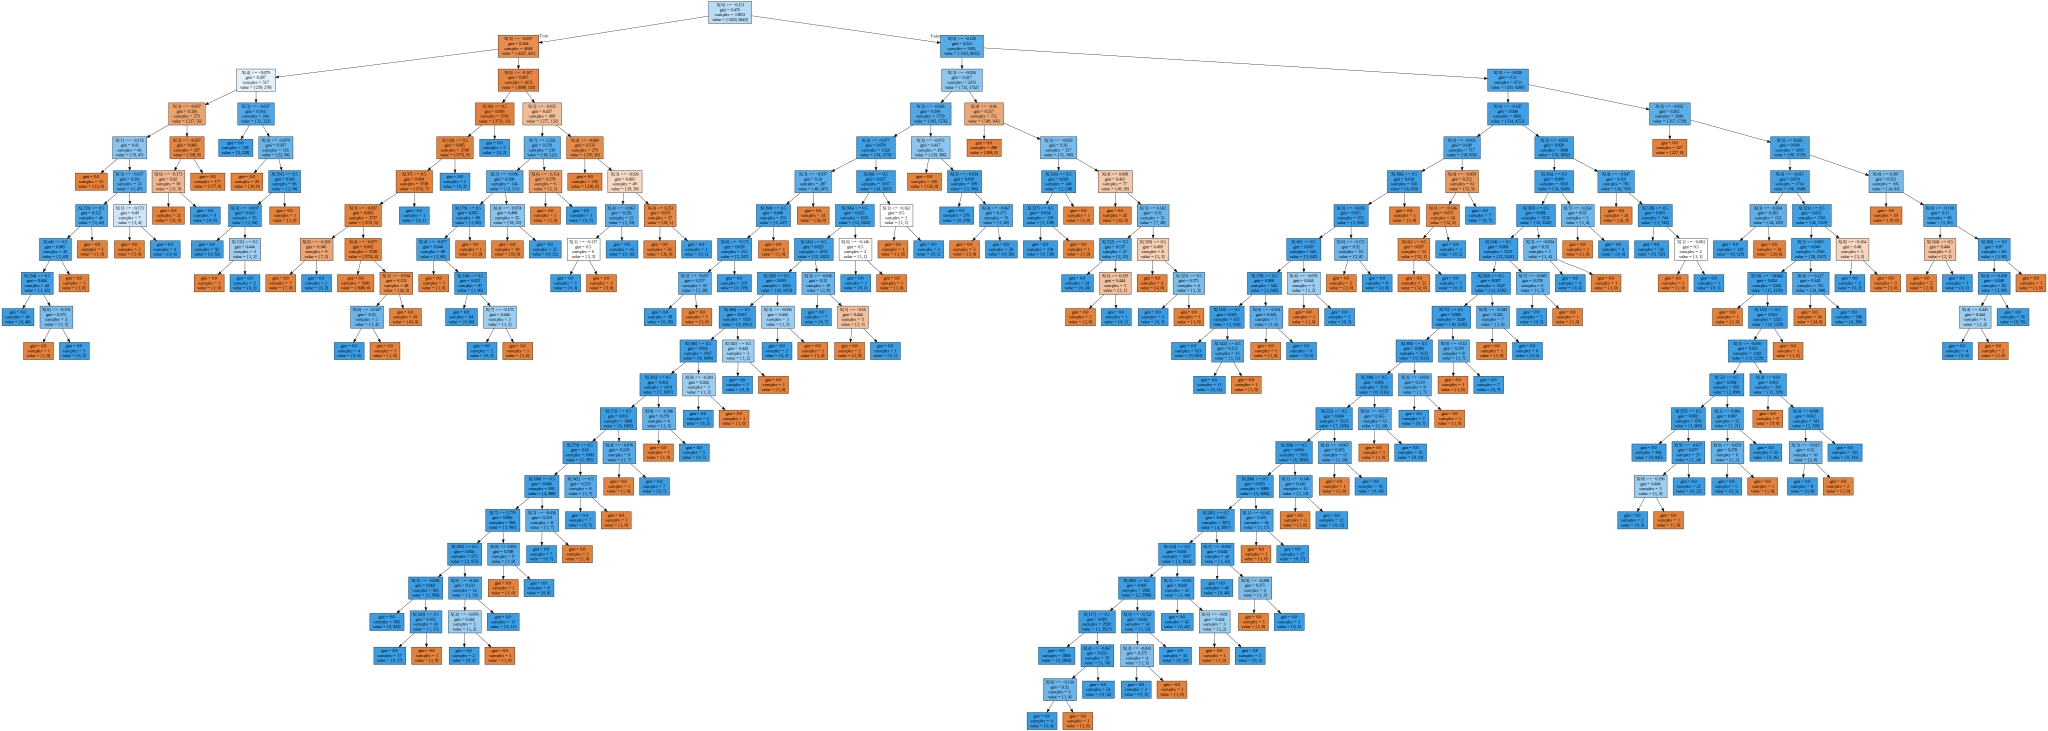

In [61]:
from graphviz import render
from graphviz import Source

tree.export_graphviz(dt_model,
                     out_file="tree3.dot",
                     #feature_names = fn, 
                     #class_names=cn,
                     filled = True)
# Convert a .dot file to .png

render("dot", "png", "tree3.dot")
# To render an existing file in a notebook

Source.from_file("tree3.dot")

# SVC

In [29]:
pipe_svc = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', SVC())
])

#Grid search Parameters
param_svc = {
            "svc__C":[1.0],
            "svc__kernel":['rbf'],
            "svc__degree":[3],
            "svc__gamma":['scale'],
            "svc__coef0":[0.0],
            "svc__shrinking":[True],
            "svc__probability":[False],
            "svc__tol":[0.001],
            "svc__cache_size":[200],
            "svc__class_weight":[None],
            "svc__verbose":[False],
            "svc__max_iter":[-1],
            "svc__decision_function_shape":['ovr'],
            "svc__break_ties":[False],
            "svc__random_state":[RSEED],
            }

grid_svc = GridSearchCV(pipe_svc,
                           param_grid=param_svc,
                           cv=5, 
                           scoring='accuracy',
                           verbose=5, 
                           n_jobs=-1)

In [ ]:
grid_svc.fit(X_train,y_train)

In [ ]:
grid_svc.best_params_

In [ ]:
svc_model = grid_svc.best_estimator_["svc"]
y_svc_pred_test = svc_model.predict(X_test)
print(sm.classification_report(y_test,y_svc_pred_test))

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_dt_pred_test), annot=True, cmap='YlGn', fmt='d');

# Random Forest

In [33]:
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier())
])

#Grid search Parameters
param_rf = {
            "rf__n_estimators":[100],
            "rf__criterion":['gini'],
            "rf__max_depth":[None],
            "rf__min_samples_split":[2],
            "rf__min_samples_leaf":[1],
            "rf__min_weight_fraction_leaf":[0.0],
            "rf__max_features":['auto'],
            "rf__max_leaf_nodes":[None],
            "rf__min_impurity_decrease":[0.0],
            "rf__min_impurity_split":[None],
            "rf__bootstrap":[True],
            "rf__oob_score":[False],
            "rf__n_jobs":[None],
            "rf__random_state":[RSEED],
            "rf__verbose":[0],
            "rf__warm_start":[False],
            "rf__class_weight":[None],
            "rf__ccp_alpha":[0.0],
            "rf__max_samples":[None],
            }

grid_rf = GridSearchCV(pipe_rf,
                           param_grid=param_rf,
                           cv=5, 
                           scoring='accuracy',
                           verbose=5, 
                           n_jobs=-1)

In [34]:
grid_rf.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['backers_count',
                                                                          'converted_pledged_amount',
                                                                          'disable_communication',
                                                                          'goal',
                          

In [41]:
grid_rf.best_params_

{'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': 42,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [35]:
rf_model = grid_rf.best_estimator_["rf"]
y_rf_pred_test = rf_model.predict(X_test)
print(sm.classification_report(y_test,y_rf_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     13527
           1       0.97      1.00      0.99     21107

    accuracy                           0.98     34634
   macro avg       0.98      0.98      0.98     34634
weighted avg       0.98      0.98      0.98     34634



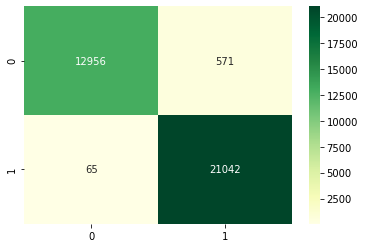

In [36]:
sns.heatmap(confusion_matrix(y_test, y_rf_pred_test), annot=True, cmap='YlGn', fmt='d');

# AdaBoost

In [37]:
pipe_ab = Pipeline([
    ('preprocessor', preprocessor),
    ('ab', AdaBoostClassifier())
])

#Grid search Parameters
param_ab = {            
            "ab__base_estimator":[None],
            "ab__n_estimators":[50],
            "ab__learning_rate":[1.0],
            "ab__algorithm":['SAMME.R'],
            "ab__random_state":[RSEED],
            }

grid_ab = GridSearchCV(pipe_ab,
                           param_grid=param_ab,
                           cv=5, 
                           scoring='accuracy',
                           verbose=5, 
                           n_jobs=-1)

In [38]:
grid_ab.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['backers_count',
                                                                          'converted_pledged_amount',
                                                                          'disable_communication',
                                                                          'goal',
                          

In [42]:
grid_ab.best_params_

{'ab__algorithm': 'SAMME.R',
 'ab__base_estimator': None,
 'ab__learning_rate': 1.0,
 'ab__n_estimators': 50,
 'ab__random_state': 42}

In [40]:
ab_model = grid_ab.best_estimator_["ab"]
y_ab_pred_test = ab_model.predict(X_test)
print(sm.classification_report(y_test,y_ab_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     13527
           1       0.97      1.00      0.99     21107

    accuracy                           0.98     34634
   macro avg       0.98      0.98      0.98     34634
weighted avg       0.98      0.98      0.98     34634



In [ ]:
sns.heatmap(confusion_matrix(y_test, y_ab_pred_test), annot=True, cmap='YlGn', fmt='d');

# Ensemble

In [ ]:
estimators = [
    ('dt', DecisionTreeClassifier(random_state=RSEED)),
    #('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(random_state=RSEED)),
    ("nb", BernoulliNB())
]

pipe_stack = Pipeline([
    ('preprocessor', preprocessor),
    ('stack', StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()))
])

In [ ]:
pipe_stack.fit(X_train, y_train)

In [ ]:
pipe_stack.get_params()

In [ ]:
y_stack_pred_test = pipe_stack.predict(X_test)
y_stack_pred_test

In [ ]:
print(sm.classification_report(y_test,y_stack_pred_test))